This notebook includes all pre-processing steps and the model used to perform the classification task.

In [264]:
!pip install wordninja


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import nltk
import pickle
import re
import wordninja
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [263]:
os.listdir('.')

['.ipynb_checkpoints',
 'DM2023-Lab2-Homework.ipynb',
 'img',
 'kaggle_formatted_data.ipynb',
 'kaggle_main.ipynb',
 'README.md',
 'submission.csv',
 'w2v100dim.kvmodel',
 'w2v100dim.kvmodel.syn1neg.npy',
 'w2v100dim.kvmodel.wv.vectors.npy',
 'xgb.json',
 'xgb.pickle.dat',
 '__pycache__']

In [215]:
data_folder = Path("../data_kaggle/")

# Data loading

In this part, I simply load the tabular data created by the kaggle_formatted_data.ipynb notebook.

In [216]:
train_data = pd.read_csv(data_folder/'train_data.csv')
test_data = pd.read_csv(data_folder/'test_data.csv')

In [217]:
print(train_data.shape)
print(test_data.shape)

(1455563, 4)
(411972, 3)


In [218]:
train_data.head()

,tweet_id,hashtags,texts,emotion
0,0x29e452,[],Huge Respect🖒 @JohnnyVegasReal talking about l...,joy
1,0x2b3819,"['spateradio', 'app']",Yoooo we hit all our monthly goals with the ne...,joy
2,0x2a2acc,[],@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,trust
3,0x2a8830,"['PUBG', 'GamersUnite', 'twitch', 'BeHealthy',...",Come join @ambushman27 on #PUBG while he striv...,joy
4,0x20b21d,"['strength', 'bones', 'God']",@fanshixieen2014 Blessings!My #strength little...,anticipation


# Text exploration

In this text exploration section, I've tried various approaches to process raw text data using the regex library, which facilitates working with regular expressions.

The following three functions were implemented :
- light_string_processing
    - Executes minimal processing on the input string.
    - Removes the LH pattern found in the data, considered as irrelevant, and converts the text to lowercase.
- moderate_string_processing
    - Conducts moderate processing on the input string.
    - Performs what light_string_processing function does
    - Also removes additional characters such as '#', '@', '_', and '-' from each tweet.
- intensive_string_processing
    - Performs what moderate_string_processing function does
    - Incorporates a specialized tool, wordninja, to address the challenge of making sense of words containing '#' and '@'.
    - Splits text without spaces into a list of words using a probabilistic concatenated word splitting approach based on unigram frequencies from the English Wikipedia.
    - The idea behind implementing this last function was to gain insights into words containing '#' and '@'.
    - ref : https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
    
Despite the enhanced capabilities of moderate_string_processing and intensive_string_processing functions, the results indicated that light_string_processing function was preferable for the classification task.

In [219]:
def light_string_processing(input_str):
    result = re.sub(r'<LH>','', input_str)
    result = re.sub(r'\s+', ' ', result)
    return result.lower()

In [220]:
def moderate_string_processing(input_str):
    result = re.sub(r'#(\w+)|<LH>|@|_|-', lambda x: x.group(1) if x.group(1) else '', input_str) # Delete hashtags or <LH>
    result = re.sub(r'\s+', ' ', result)
    return result.lower()

In [221]:
def intensive_string_processing(input_str):
    replacements  = {}
    suspicious_words = re.findall(r'[@#]\w+', input_str)
    for suspicious_word in suspicious_words:
        replacements[suspicious_word] = wordninja.split(suspicious_word)
    for suspicious_word, replacement in replacements.items():
        input_str = input_str.replace(suspicious_word, " ".join(replacement))
    result = re.sub(r'#(\w+)|<LH>|@|_|-', lambda x: x.group(1) if x.group(1) else '', input_str)
    result = re.sub(r'\s+', ' ', result)
    return result.lower()

In [222]:
specific_text = train_df.loc[1013690, 'texts']
print('Original text :', specific_text)
print('\n')
print('light_string_processing :', light_string_processing(specific_text))
print('\n')
print('moderate_string_processing :', moderate_string_processing(specific_text))
print('\n')
print('intensive_string_processing :', intensive_string_processing(specific_text))

Original text : Good morning. 😘💏❤ <LH> #Productivity <LH> #life #SundayMorning <LH> #WorkFromHome <LH>


light_string_processing : good morning. 😘💏❤ #productivity #life #sundaymorning #workfromhome 


moderate_string_processing : good morning. 😘💏❤ productivity life sundaymorning workfromhome 


intensive_string_processing : good morning. 😘💏❤ productivity life sunday morning work from home 


In [223]:
process_input_string = light_string_processing

# Preprocessing

In this section, I've decided to tokenize the processed text created using TweetTokenizer and SnowballStemmer.

TweetTokenizer provides specialized tokenization for tweets. It preserves emoticons and handle unique features like hashtags and mentions.

SnowballStemmer uses the snowball stemming algorithm to linguistically reduce words to their base forms. I have tried several stemmers provided by the scikit learn library and this one performed better.

In [224]:
from nltk.tokenize.casual import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

In [225]:
tweet_tokenizer = TweetTokenizer()
stemmer = SnowballStemmer("english")

In [226]:
def preprocessing(df):
    df['processed_texts'] = df['texts'].apply(process_input_string)
    df['processed_texts'] = df['processed_texts'].apply(lambda x: tweet_tokenizer.tokenize(x))
    df['processed_texts'] = df['processed_texts'].apply(lambda x: [stemmer.stem(i) for i in x])
    return df              

In [227]:
df = preprocessing(train_data)

In [228]:
print(df.shape)

(1455563, 5)


Taking into account the variations in sentence length and the associated labeled emotions (as you can observe below), I decided to introduce a new feature, specifically the sentence length, to enhance the analysis.

In [229]:
df['len'] = df['processed_texts'].apply(len)

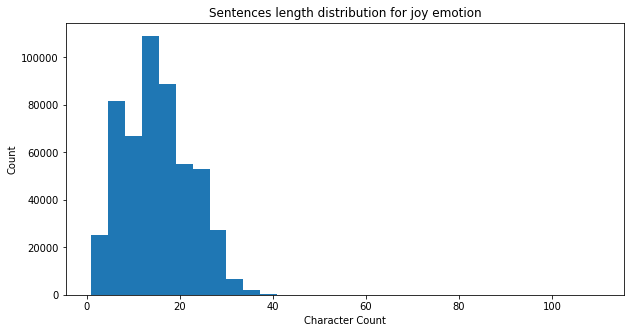

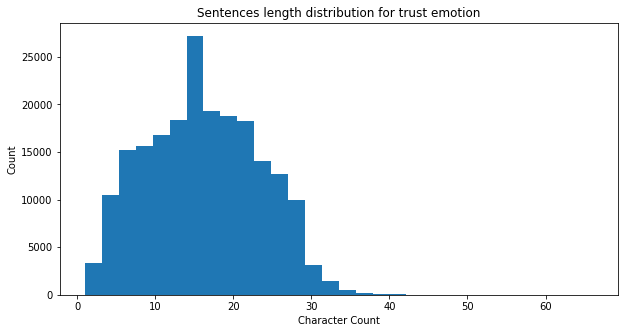

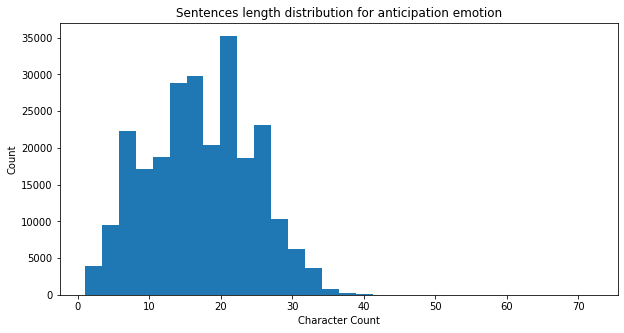

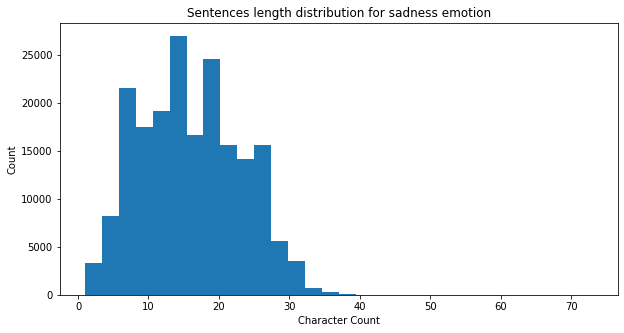

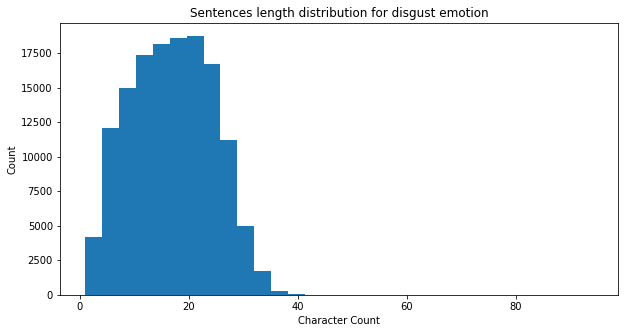

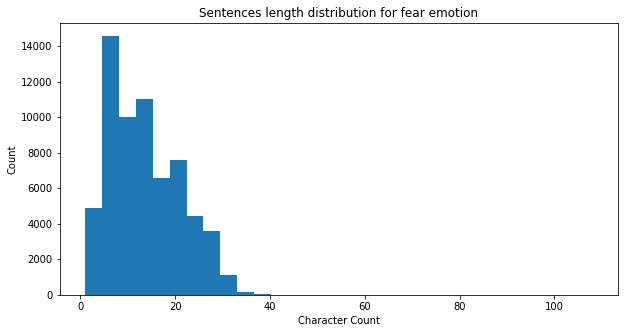

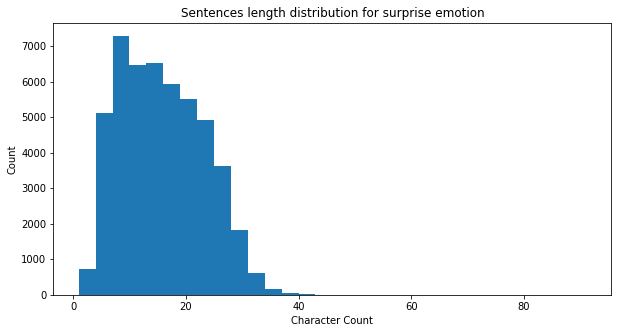

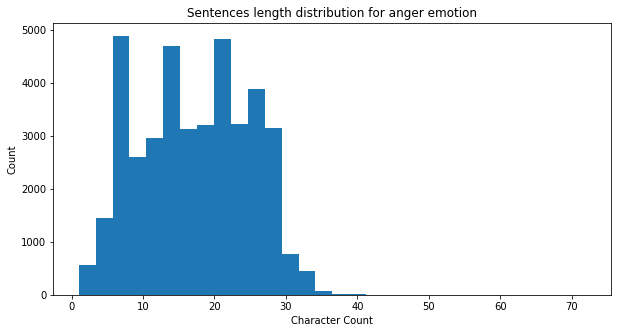

In [230]:
for emotion in df['emotion'].unique():
    plt.figure(figsize=(10, 5))
    filter_emotion = df['emotion'] == emotion
    plt.hist(df.loc[filter_emotion, 'len'], bins=30)
    plt.xlabel('Character Count')
    plt.ylabel('Count')
    plt.title(f'Sentences length distribution for {emotion} emotion')

In [231]:
print(df.shape)

(1455563, 6)


In [232]:
from sklearn.model_selection import train_test_split
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)

In [233]:
print(train_df.shape)
print(validation_df.shape)

(1164450, 6)
(291113, 6)


In [234]:
train_df.head()

,tweet_id,hashtags,texts,emotion,processed_texts,len
834097,0x2671c2,['Angels'],Some of her abilities are clearly a result of ...,joy,"[some, of, her, abil, are, clear, a, result, o...",12
355739,0x2888c7,[],Closed Sell 2.3 Lots EURUSD 1.16126 for +10.0 ...,joy,"[close, sell, 2.3, lot, eurusd, 1.16126, for, ...",15
625638,0x2af3c1,[],"""The manna the Israelites received in the wild...",anticipation,"["", the, manna, the, israelit, receiv, in, the...",26
678647,0x246f08,[],"""Taylor Swift is a white supremacist cause she...",disgust,"["", taylor, swift, is, a, white, supremacist, ...",27
441397,0x307794,[],Im pretty sure there's a bug going around work...,joy,"[im, pretti, sure, there, a, bug, go, around, ...",27


I chose to normalize the length data to ensure that the algorithm is not disproportionately influenced by this feature.

In [235]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df['len'] = scaler.fit_transform(train_df['len'].values.reshape(len(train_df['len']), 1))
validation_df['len'] = scaler.transform(validation_df['len'].values.reshape(len(validation_df['len']), 1))

In [236]:
train_df.head()

,tweet_id,hashtags,texts,emotion,processed_texts,len
834097,0x2671c2,['Angels'],Some of her abilities are clearly a result of ...,joy,"[some, of, her, abil, are, clear, a, result, o...",-0.537723
355739,0x2888c7,[],Closed Sell 2.3 Lots EURUSD 1.16126 for +10.0 ...,joy,"[close, sell, 2.3, lot, eurusd, 1.16126, for, ...",-0.126610
625638,0x2af3c1,[],"""The manna the Israelites received in the wild...",anticipation,"["", the, manna, the, israelit, receiv, in, the...",1.380806
678647,0x246f08,[],"""Taylor Swift is a white supremacist cause she...",disgust,"["", taylor, swift, is, a, white, supremacist, ...",1.517843
441397,0x307794,[],Im pretty sure there's a bug going around work...,joy,"[im, pretti, sure, there, a, bug, go, around, ...",1.517843


# Word embeddings with Word2Vec

I chose to utilize the Word2Vec model trained on my dataset to capture semantic relationships and contextual similarities between words. It facilitates the learning of meaningful word associations and allows the model to better understand the nuanced context within the dataset, which can be essential in the emotion classification task we have to perform.

In [237]:
training_corpus = train_df['processed_texts'].values

In [238]:
from gensim.models import Word2Vec
vector_dim = 100
window_size = 5
min_count = 1
training_epochs = 20
word2vec_model = Word2Vec(sentences=training_corpus,
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_epochs)

In [239]:
def calculate_average_word_vector_representation(sentence):
    valid_words_in_sentence = []
    for word in sentence:
        if word in word2vec_model.wv:
            valid_words_in_sentence.append(word)
        else:
            pass
    if len(valid_words_in_sentence) != 0:
        word_vectors_for_valid_words = [word2vec_model.wv[word] for word in valid_words_in_sentence]
        word_vectors_array = np.array(word_vectors_for_valid_words)
        sentence_representation_mean = word_vectors_array.mean(axis=0)
        return sentence_representation_mean
    else:
        return np.zeros(100)

For each sentence, we have its average representation in a 100-dimensional space.

In [240]:
X_train = np.array([calculate_average_word_vector_representation(s) for s in train_df['processed_texts']])

After some tests, I opted to exclude the sentence length feature from consideration due to lower performance observed in the results.

In [241]:
# len_train = train_df['len'].values.reshape(X_train.shape[0], 1)
# X_train = np.hstack((X_train, len_train))

In [242]:
y_train = train_df['emotion']

In [243]:
print(X_train.shape)
print(y_train.shape)

(1164450, 100)
(1164450,)


In [244]:
X_validation = np.array([calculate_average_word_vector_representation(s) for s in validation_df['processed_texts']])

In [245]:
# len_validation = validation_df['len'].values.reshape(X_validation.shape[0], 1)
# X_validation = np.hstack((X_validation, len_validation))

In [246]:
y_validation = validation_df['emotion']

In [247]:
print(X_validation.shape)
print(y_validation.shape)

(291113, 100)
(291113,)


In [248]:
word2vec_model.save('./w2v100dim.kvmodel')

# Model

For the given task, I experimented with five models : SVM, Decision Tree, Random Forest, Naive Bayes, and XGBoostClassifier. I finally opted for the XGBoostClassifier model as it demonstrated superior performance compared to the other models.

## XGBoostClassifier

XGBoostClassifier demonstrated its effectiveness avoiding the overfitting I could encounter with other algorithms.

XGBoost stands for eXtreme Gradient Boosting

It uses an ensemble of decision trees, employing a gradient boosting framework to minimizes the loss function to iteratively improve the model performance.

In [249]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_validation = label_encoder.transform(y_validation)

In [250]:
eval_set = [(X_train, y_train),(X_validation, y_validation)]

In [251]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(
    n_estimators=300,  # Increase the number of trees
    learning_rate=0.1,  # Higher learning rate 
    max_depth=6, 
    min_child_weight=1, 
    subsample=0.8,  # Use a fraction of the training data for each tree
    colsample_bytree=0.8,  # Use a fraction of features for each tree
    verbosity=2
)
xgb_clf.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=20)

[0]	validation_0-mlogloss:2.00932	validation_1-mlogloss:2.00949
[1]	validation_0-mlogloss:1.95223	validation_1-mlogloss:1.95261
[2]	validation_0-mlogloss:1.90401	validation_1-mlogloss:1.90452
[3]	validation_0-mlogloss:1.86227	validation_1-mlogloss:1.86295
[4]	validation_0-mlogloss:1.82493	validation_1-mlogloss:1.82615
[5]	validation_0-mlogloss:1.79207	validation_1-mlogloss:1.79355
[6]	validation_0-mlogloss:1.76293	validation_1-mlogloss:1.76464
[7]	validation_0-mlogloss:1.73697	validation_1-mlogloss:1.73894
[8]	validation_0-mlogloss:1.71309	validation_1-mlogloss:1.71529
[9]	validation_0-mlogloss:1.69171	validation_1-mlogloss:1.69433
[10]	validation_0-mlogloss:1.67224	validation_1-mlogloss:1.67510
[11]	validation_0-mlogloss:1.65469	validation_1-mlogloss:1.65777
[12]	validation_0-mlogloss:1.63847	validation_1-mlogloss:1.64187
[13]	validation_0-mlogloss:1.62364	validation_1-mlogloss:1.62732
[14]	validation_0-mlogloss:1.60970	validation_1-mlogloss:1.61361
[15]	validation_0-mlogloss:1.59717	

[126]	validation_0-mlogloss:1.32732	validation_1-mlogloss:1.36103
[127]	validation_0-mlogloss:1.32663	validation_1-mlogloss:1.36060
[128]	validation_0-mlogloss:1.32594	validation_1-mlogloss:1.36014
[129]	validation_0-mlogloss:1.32523	validation_1-mlogloss:1.35969
[130]	validation_0-mlogloss:1.32453	validation_1-mlogloss:1.35921
[131]	validation_0-mlogloss:1.32385	validation_1-mlogloss:1.35878
[132]	validation_0-mlogloss:1.32319	validation_1-mlogloss:1.35838
[133]	validation_0-mlogloss:1.32252	validation_1-mlogloss:1.35794
[134]	validation_0-mlogloss:1.32185	validation_1-mlogloss:1.35750
[135]	validation_0-mlogloss:1.32120	validation_1-mlogloss:1.35712
[136]	validation_0-mlogloss:1.32057	validation_1-mlogloss:1.35673
[137]	validation_0-mlogloss:1.31993	validation_1-mlogloss:1.35632
[138]	validation_0-mlogloss:1.31934	validation_1-mlogloss:1.35596
[139]	validation_0-mlogloss:1.31873	validation_1-mlogloss:1.35555
[140]	validation_0-mlogloss:1.31809	validation_1-mlogloss:1.35513
[141]	vali

[251]	validation_0-mlogloss:1.26546	validation_1-mlogloss:1.32723
[252]	validation_0-mlogloss:1.26509	validation_1-mlogloss:1.32707
[253]	validation_0-mlogloss:1.26473	validation_1-mlogloss:1.32692
[254]	validation_0-mlogloss:1.26437	validation_1-mlogloss:1.32676
[255]	validation_0-mlogloss:1.26399	validation_1-mlogloss:1.32658
[256]	validation_0-mlogloss:1.26360	validation_1-mlogloss:1.32641
[257]	validation_0-mlogloss:1.26322	validation_1-mlogloss:1.32626
[258]	validation_0-mlogloss:1.26285	validation_1-mlogloss:1.32610
[259]	validation_0-mlogloss:1.26246	validation_1-mlogloss:1.32594
[260]	validation_0-mlogloss:1.26210	validation_1-mlogloss:1.32577
[261]	validation_0-mlogloss:1.26175	validation_1-mlogloss:1.32562
[262]	validation_0-mlogloss:1.26139	validation_1-mlogloss:1.32546
[263]	validation_0-mlogloss:1.26100	validation_1-mlogloss:1.32527
[264]	validation_0-mlogloss:1.26066	validation_1-mlogloss:1.32515
[265]	validation_0-mlogloss:1.26028	validation_1-mlogloss:1.32497
[266]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [252]:
xgb_clf.save_model("./xgb.json")
pickle.dump(xgb_clf, open("./xgb.pickle.dat", "wb"))

In [253]:
results_xgb_clf = xgb_clf.evals_result()

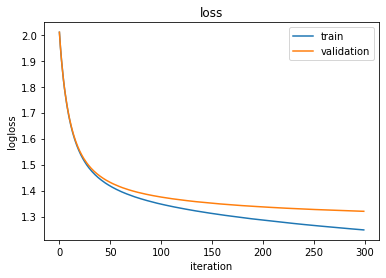

In [254]:
# Plot learning curves
plt.plot(results_xgb_clf['validation_0']['mlogloss'], label='train')
plt.plot(results_xgb_clf['validation_1']['mlogloss'], label='validation')
plt.title('loss')
plt.xlabel('iteration')
plt.ylabel('logloss')
plt.legend()
plt.show()

In [255]:
y_train_pred = xgb_clf.predict(X_train)

In [256]:
y_validation_pred = xgb_clf.predict(X_validation)

# Results evaluation

In [257]:
## accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_validation = accuracy_score(y_true=y_validation, y_pred=y_validation_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_validation, 2)))

training accuracy: 0.54
testing accuracy: 0.52


In [258]:
## precision, recall, f1-score,
from sklearn.metrics import classification_report

classification_report_validation = classification_report(y_true=y_validation, y_pred=y_validation_pred)
print(classification_report(y_true=y_validation, y_pred=y_validation_pred))

              precision    recall  f1-score   support

           0       0.60      0.14      0.22      7964
           1       0.60      0.49      0.54     49725
           2       0.40      0.35      0.37     27892
           3       0.60      0.29      0.39     12955
           4       0.52      0.83      0.64    103089
           5       0.44      0.43      0.44     38835
           6       0.87      0.10      0.18      9750
           7       0.57      0.19      0.28     40903

    accuracy                           0.52    291113
   macro avg       0.57      0.35      0.38    291113
weighted avg       0.54      0.52      0.48    291113



# submission.csv

In [259]:
from sklearn.metrics import f1_score
f1_score(y_validation, y_validation_pred, average=None).mean()

0.3833199728195718

In [260]:
test_data = preprocessing(test_data)
test_data['len'] = test_data['processed_texts'].apply(len)
test_data['len'] = scaler.transform(test_data['len'].values.reshape(len(test_data['len']), 1))
X_test = np.array([calculate_average_word_vector_representation(s) for s in test_data['processed_texts']])
# len_test = test_data['len'].values.reshape(X_test.shape[0], 1)
# X_test = np.hstack((X_test, len_test))
y_test = xgb_clf.predict(X_test)
y_label = label_encoder.inverse_transform(y_test)
test_data['emotion'] = y_label

In [261]:
test_data.drop(['hashtags', 'texts', 'processed_texts', 'len'], axis=1).rename(columns={'tweet_id':'id'}).to_csv('./submission.csv', index=False)

In [262]:
test_data.drop(['hashtags', 'texts', 'processed_texts', 'len'], axis=1).rename(columns={'tweet_id':'id'})

,id,emotion
0,0x28cc61,joy
1,0x2db41f,sadness
2,0x2466f6,joy
3,0x23f9e9,joy
4,0x1fb4e1,joy
...,...,...
411967,0x2c4dc2,joy
411968,0x31be7c,anticipation
411969,0x1ca58e,joy
411970,0x35c8ba,joy
